In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as td
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import cv2

## Obj: classify handwritten digit images into their respective true number

#### Loading and preprocessing the MNIST handwritten digit data

In [14]:
raw_csv_train = pd.read_csv("../datasets/mnist_train.csv")
raw_csv_test = pd.read_csv("../datasets/mnist_test.csv")

In [3]:
x_train = raw_csv_train.iloc[:, 1:].values.reshape(-1, 28, 28)
y_train =raw_csv_train.iloc[:, 0].values
x_test = raw_csv_test.values.reshape(-1, 28, 28)

In [4]:
print(f"train X dim: {x_train.shape}")
print(f"train y dim: {y_train.shape}")
print(f"test X dim: {x_test.shape}")

train X dim: (42000, 28, 28)
train y dim: (42000,)
test X dim: (28000, 28, 28)


#### Example data

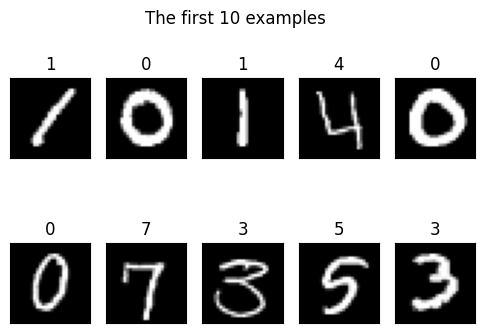

In [5]:
NROWS = 2
NCOLS = 5

fig, ax = plt.subplots(ncols=NCOLS, nrows=NROWS, dpi=100)

counter = 0
for i in range(NROWS):
    for j in range(NCOLS):
        ax[i, j].imshow(x_train[counter], cmap="gray")
        ax[i, j].set_title(y_train[counter])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        counter+=1
    
fig.suptitle(f"The first {NROWS*NCOLS} examples")

plt.show()

## What is a convolution?

There's a slight difference between the purely mathematical convolution and the applied image-esque convolution

#### Mathematically speaking

$$(f * g)(x)=\int_{-\infty}^{\infty} f(t) g(x-t) d t$$

for example, if $f(x) = 2x+1$ and $g(x)=4x+3$, then $(f*g)(2)=$... well i dont really know :p. Let's just get right into the CS application


#### In computer science

arr = [1,2,3,4,5] <br>
kernel = [1,2,3] <br>

to find $\text{convolution}(arr, kernel)$, turn the kernel backward, then slide it across arr to perform something like a dot product

$\text{convolution}(arr, kernel)[0] = 1 \cdot 1 = 1 $ <br>
$\text{convolution}(arr, kernel)[1] = 1 \cdot 2 + 2 \cdot 1 = 4 $ <br>
$\text{convolution}(arr, kernel)[2] = 1 \cdot 3 + 2 \cdot 2 + 3 \cdot 1 = 10 $ <br>
$\text{convolution}(arr, kernel)[3] = 2 \cdot 3 + 3 \cdot 2 + 4 \cdot 1 = 16 $ <br>
$\text{convolution}(arr, kernel)[4] = 3 \cdot 3 + 4 \cdot 2 + 5 \cdot 1 = 22 $ <br>
$\text{convolution}(arr, kernel)[5] = 4 \cdot 3 + 5 \cdot 2 = 22 $ <br>
$\text{convolution}(arr, kernel)[6] = 5 \cdot 3 = 15 $ <br>

the number of convolution for an arr (sized $n$) and a kernel (sized $m$) is $n+m-1$

In [3]:
arr = np.array([1, 2, 3, 4, 5])
kernel = np.array([1, 2, 3])
print(f"convolution(arr, kernel): {np.convolve(arr, kernel)}")

convolution(arr, kernel): [ 1  4 10 16 22 22 15]


#### Intermezzo: Convolution for calculating moving average

Convolution can be used to calculate moving average. Given a lag $m$, a 1D array $A$, and a 1D array $a$ with components $((\frac{1}{m})_{1}, (\frac{1}{m})_{2}, ..., (\frac{1}{m})_{m})$, the moving average of $A$ will start at index $(a-1)$ and end at $(n-lag)$ of $\text{convolve}(A,a)$

In [4]:
# Testing moving average data
data_mv_avg = np.random.randint(1,20, size=(20))
data_mv_avg

# Normal moving average function
def moving_average(data, lag):
    moving_averages = []
    for i in range(len(data)):
        if i < lag - 1:
            # If not enough data points for the specified lag, use NaN or None as placeholder
            moving_averages.append(None) 
        else:
            # Calculate the moving average for the current position
            avg = sum(data[i - lag + 1:i + 1]) / lag
            moving_averages.append(avg)
    return moving_averages

print("normal moving average func:")
print(np.array(moving_average(data_mv_avg, 5)[4:]))
print()

avg_arr = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
print("convolving moving average:")
print(np.convolve(data_mv_avg, avg_arr)[4:-4])

normal moving average func:
[11.2 10.  10.2 10.4 12.  10.4 12.  12.  13.6 12.4 13.2 11.4 10.8 10.
  9.2 10.8]

convolving moving average:
[11.2 10.  10.2 10.4 12.  10.4 12.  12.  13.6 12.4 13.2 11.4 10.8 10.
  9.2 10.8]


#### What convolution can do for image processing

Convolution can be used to transform images s.t. a neural network can detect meaningful feature from an image. 
- For example, to detect edges we can use convolution to calculate the image gradient. Image gradient can identify the pixels at which the most sudden intensity will value occur, much like edges. Technically, we can use sobel or laplacian filter to convolve with the image.

#### Sobel edge detection example

In [12]:
# unfortunately, np.convolve does not support multidimensional array (such as images). Hence, we use opencv

# Load the image
image = cv2.imread('../datasets/puppy.jpg', cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale

# Apply Sobel filter for edge detection
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
"""
the x_filter:
[ -1  0  1 ]
[ -2  0  2 ]
[ -1  0  1 ]
"""
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
"""
the y_filter:
[ -1 -2 -1 ]
[  0  0  0 ]
[  1  2  1 ]
"""

# combining x and y filter by calculating magnitude of the gradient
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

# Convert to 8-bit image for viewing
def convert_8bit(x):
    result = np.uint8(255 * x / np.max(x))
    return result

sobel_x_view = convert_8bit(sobel_x)
sobel_y_view = convert_8bit(sobel_y)
gradient_magnitude_view = convert_8bit(gradient_magnitude)

#### Sobel filter visualization

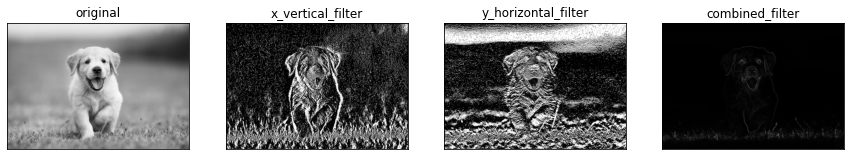

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(15,7))
ax1, ax2, ax3, ax4 = ax

ax1.imshow(image, cmap="gray")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("original")

ax2.imshow(sobel_x_view, cmap="gray")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("x_vertical_filter")

ax3.imshow(sobel_y_view, cmap="gray")
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title("y_horizontal_filter")

ax4.imshow(gradient_magnitude_view, cmap="gray")
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title("combined_filter")

plt.show()

## Convolutional Neural Network Architecture

A convolutional layer is layer wherein the neural network calculate its own filter s.t. it can detect a particular detail that the neural network see fit. Intuitively, it enables the neural network to focus on a specific feature of an image.

Characteristics of a convolutional layer:
- It has transition equivariance, meaning no matter where the object of interest in the image, the resulting convolution of the object of interest will look the same (does that make sense? HAHA :p)
- It does not have inherent transition invariance, but it can be introduced with a pooling layer, by which only the important object of interest are being passed on to the next layer

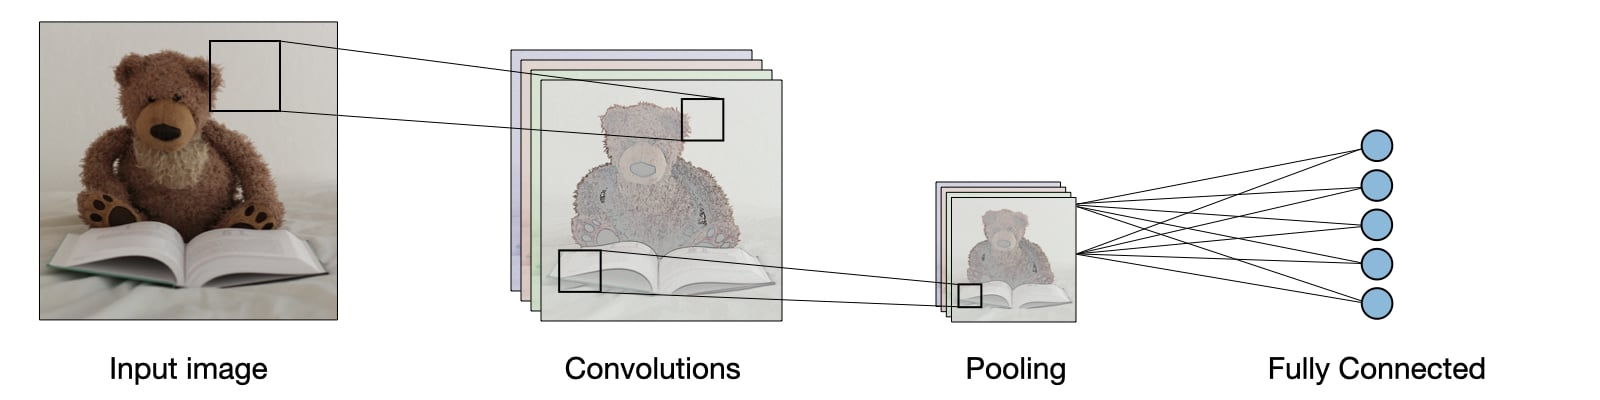

Above is the illustration of the CNN process with 1 convolution layer and 1 pooling layer. The picture should be self-explanatory. Credit: Stanford Education

#### The model specification (assisted by ChatGPT)

In [28]:
# Build the CNN model
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # (28,28,1) due to grayscale. (28, 28, 3) if color
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

#### Training process

In [29]:
# Preprocess the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape the data to fit the model input
x_train =n x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Train the model
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1313/1313 [==============================] - 114s 73ms/step - loss: 0.1525 - accuracy: 0.9527
Epoch 2/5
1313/1313 [==============================] - 100s 76ms/step - loss: 0.0469 - accuracy: 0.9852
Epoch 3/5
1313/1313 [==============================] - 108s 82ms/step - loss: 0.0308 - accuracy: 0.9902
Epoch 4/5
1313/1313 [==============================] - 111s 84ms/step - loss: 0.0242 - accuracy: 0.9922
Epoch 5/5
1313/1313 [==============================] - 109s 83ms/step - loss: 0.0168 - accuracy: 0.9944


#### Evaluating accuracy on the train set

In [30]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_train, y_train)
print(f'Test accuracy: {test_acc}')

1313/1313 [==============================] - 53s 24ms/step - loss: 0.0129 - accuracy: 0.9959
Test accuracy: 0.9958809614181519


#### Visualizing the evaluation

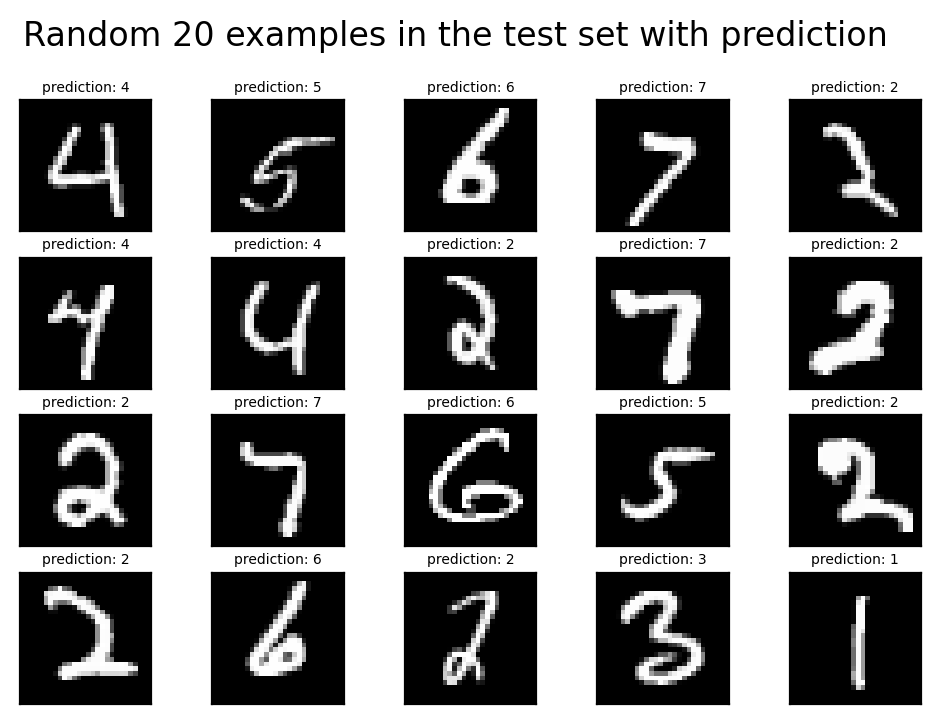

In [33]:
NROWS = 4
NCOLS = 5
image_x = x_test


index = np.random.choice(len(image_x), size=NROWS*NCOLS, replace=False)
prediction = np.argmax(model.predict(image_x[index]), axis=1)

fig, ax = plt.subplots(ncols=NCOLS, nrows=NROWS, dpi=200)

counter = 0
for k in range(NROWS):
    for l in range(NCOLS):
        prediction_i = prediction[counter]
        x_i = image_x[index[counter]]
        ax[k, l].imshow(x_i, cmap="gray")
        ax[k, l].set_title(f"prediction: {prediction_i}", fontsize=5,
                           pad=3)
        ax[k, l].set_xticks([])
        ax[k, l].set_yticks([])
        counter+=1

fig.suptitle(f"Random {NROWS*NCOLS} examples in the test set with prediction")

plt.show()

looks good enough, lets submit them

In [47]:
prediction_submit = np.argmax(model.predict(x_test), axis=1)
df_submit = pd.DataFrame(prediction_submit)
df_submit.index+=1
df_submit = df_submit.reset_index()
df_submit = df_submit.rename({"index":"ImageId", 0:"Label"}, axis=1)

In [49]:
df_submit.to_csv("submission_mnist.csv", index=False)

Resulting accuracy on kaggle : 0.98764 (rank 675)

#### Using paint to create user generated dataset

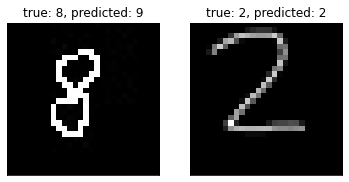

In [50]:
# This image is originally 28x28
image_path = '../datasets/created_test_mnist.jpg'  # Replace with the path to your image
img = Image.open(image_path).convert('L')  # 'L' mode for grayscale

# This image is originally 700x700
image_path_2 = '../datasets/created_test_mnist2.jpg'  
img_2 = Image.open(image_path_2).convert('L')  

# Resize the second image to 28x28 pixels
img_2 = img_2.resize((28, 28))

# Invert the image (to black and white)
img = Image.eval(img, lambda x: 255 - x)
img_2 = Image.eval(img_2, lambda y: 255 - y)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(img, cmap="gray")
ax[1].imshow(img_2, cmap="gray")

# Normalize the pixel values to the range [0, 1]
img = np.array(img) / 255.0
img_2 = np.array(img_2) / 255.0

# Reshape the image to match the input shape expected by the model
img = img.reshape(1, 28, 28, 1)
img_2 = img_2.reshape(1, 28, 28, 1)


ax[0].set_title(f"true: 8, predicted: {np.argmax(model.predict(img))}")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].set_title(f"true: 2, predicted: {np.argmax(model.predict(img_2))}")
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

#### Saving the model s.t. i dont need to train everytime i open the notebook -_-

In [51]:
model.save('MNISTClassifier.h5')

 nice wkwkwk